In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path

import torch
from tqdm.autonotebook import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pytorch3d

from utils import utils
import deformation.losses as def_losses
from deformation.semantic_discriminator_loss import SemanticDiscriminatorLoss 
from semantic_discriminator_trainer import train
from deformation.semantic_discriminator_dataset import SemanticDiscriminatorDataset
from deformation.semantic_discriminator_net import SemanticDiscriminatorNetwork
from adversarial.datasets import GenerationDataset, ShapenetRendersDataset, ShapenetPointsDataset

%matplotlib notebook

In [4]:
gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))
cfg_path = "configs/default.yaml"
cfg = utils.load_config(cfg_path, "configs/default.yaml")

In [9]:
shapenet_points_dataset = ShapenetPointsDataset(cfg)
print(len(shapenet_points_dataset))
print(torch.min(shapenet_points_dataset.cached_sampled_points))


6778
tensor(-0.4895)


torch.Size([1502, 3])


<IPython.core.display.Javascript object>


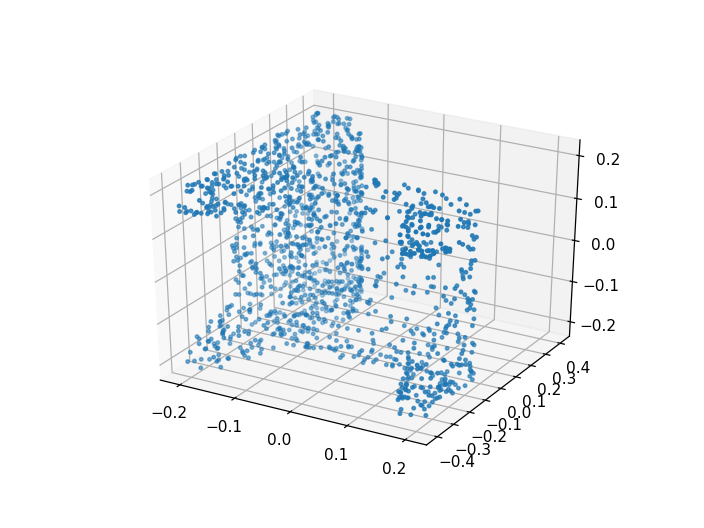

In [19]:
points = shapenet_points_dataset.__getitem__(25)
print(points.shape)
pointcloud = points.numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = pointcloud[:,0]
y = pointcloud[:,1]
z = pointcloud[:,2]
ax.scatter(x,y,z, marker = '.')

In [13]:
shapenet_points_dataset = ShapenetPointsDataset(cfg)
semantic_dis_loader = torch.utils.data.DataLoader(shapenet_points_dataset, batch_size=16, num_workers=4, shuffle=True)
for batch in tqdm(semantic_dis_loader):
    pass

In [14]:
from torch.utils.data.dataloader import default_collate
# input should be a list of dicts
def gen_data_collate(batch):
    elem = batch[0]
    out = {}
    for key in elem:
        if isinstance(elem[key], pytorch3d.structures.meshes.Meshes):
            out[key] = pytorch3d.structures.join_meshes_as_batch([d[key] for d in batch], include_textures=True)
        else:
            out[key] = default_collate([d[key] for d in batch])

    #out =  {key: default_collate([d[key] for d in batch]) for key in elem}
    return out

generation_dataset = GenerationDataset(cfg)


Loading cached generation dataset...


<IPython.core.display.Javascript object>


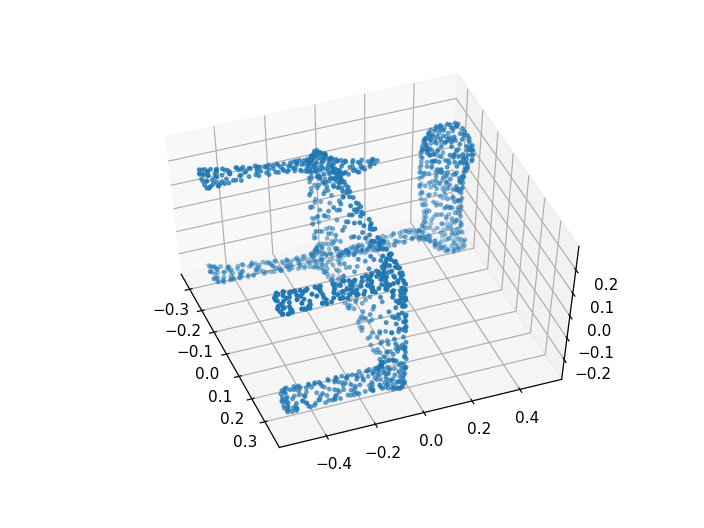

In [18]:
pointcloud = generation_dataset.__getitem__(10)['mesh_verts'].numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = pointcloud[:,0]
y = pointcloud[:,1]
z = pointcloud[:,2]
ax.scatter(x,y,z, marker = '.')

In [ ]:
generation_loader = torch.utils.data.DataLoader(generation_dataset, batch_size=16, num_workers=4, shuffle=True, collate_fn=gen_data_collate, drop_last=True)
for batch in tqdm(generation_loader):
    pprint.pprint(batch)
    break

In [9]:
import numpy as np
dis_batch_acc_history = []
for i in range(20):
    print(dis_batch_acc_history)
    dis_batch_acc_history.insert(0,i)
    if len(dis_batch_acc_history) > 10:
        dis_batch_acc_history.pop()
        print(np.average(dis_batch_acc_history))

[]
[0]
[1, 0]
[2, 1, 0]
[3, 2, 1, 0]
[4, 3, 2, 1, 0]
[5, 4, 3, 2, 1, 0]
[6, 5, 4, 3, 2, 1, 0]
[7, 6, 5, 4, 3, 2, 1, 0]
[8, 7, 6, 5, 4, 3, 2, 1, 0]
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
5.5
[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
6.5
[11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
7.5
[12, 11, 10, 9, 8, 7, 6, 5, 4, 3]
8.5
[13, 12, 11, 10, 9, 8, 7, 6, 5, 4]
9.5
[14, 13, 12, 11, 10, 9, 8, 7, 6, 5]
10.5
[15, 14, 13, 12, 11, 10, 9, 8, 7, 6]
11.5
[16, 15, 14, 13, 12, 11, 10, 9, 8, 7]
12.5
[17, 16, 15, 14, 13, 12, 11, 10, 9, 8]
13.5
[18, 17, 16, 15, 14, 13, 12, 11, 10, 9]
14.5
